# Neural Networks Demystified

These notes based on the [Neural Networks Demystified](https://www.youtube.com/playlist?list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU) YouTube playlist.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

> `%pylab inline` (or percentage-function_name) is a "magic function" that can be called within Interactive Python.
> - See https://stackoverflow.com/questions/20961287/what-is-pylab
> - See [this answer](https://stackoverflow.com/a/24338062/567863) as to why it's **_best to not use it_** and instead be more explicit.

## Sigmoid Function

$$
S(x) = \frac{1}{1 + e^{-x}} = \frac{e^{x}}{e^{x} + 1}
$$

Formula from [Wikipedia](https://en.wikipedia.org/wiki/Sigmoid_function)

In [3]:
def sigmoid(z):
    # Apply sigmoid activation function to scalar, vector, or matrix
    # represents first version of the equation above
    return 1 / (1 + np.exp(-z))

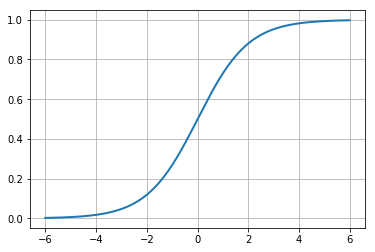

In [4]:
test_input = np.arange(-6, 6, 0.01) # Return evenly spaced values of distance step within a given interval.
plt.plot(test_input, sigmoid(test_input), linewidth=2)
plt.grid(1)

In [5]:
sigmoid(1) # scalar

0.7310585786300049

In [6]:
sigmoid(np.array([-1, 0, 1])) # vector

array([0.26894142, 0.5       , 0.73105858])

In [7]:
sigmoid(np.random.randn(3, 3)) # matrix

array([[0.51443082, 0.69685168, 0.20587383],
       [0.33548923, 0.22320401, 0.90950071],
       [0.48417196, 0.65850125, 0.33961611]])

> Note: [`randn`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html)

In [8]:
def sigmoid_prime(z):
    # Derivative of sigmoid function
    return np.exp(-z) / (1 + np.exp(-z))**2

## Create training data set

- `x`: (hours sleeping, hours studying)
- `y`: Score on test (between 0 and 100)

In [9]:
x = np.array(([3, 5], [5, 1], [10, 2]), dtype=float)
y = np.array(([75], [82], [93]), dtype=float)

In [10]:
x

array([[ 3.,  5.],
       [ 5.,  1.],
       [10.,  2.]])

In [11]:
y

array([[75.],
       [82.],
       [93.]])

## Normalise data

This is a supervised regression problem. Supervised as examples have inputs and outputs. Regression because it's predicting a test score, which is a continuous output.

Since all data in the training data is positive, we can scale the data in standardised units by dividing each value by the maximum value for each variable, resulting in a scaling of the data between 0 and 1.

In [12]:
scaled_x = x / np.amax(x, axis=0)
scaled_y = y / 100 # Max score is 100

In [13]:
scaled_x

array([[0.3, 1. ],
       [0.5, 0.2],
       [1. , 0.4]])

In [14]:
scaled_y

array([[0.75],
       [0.82],
       [0.93]])

In [15]:
print(scaled_x.shape, scaled_y.shape)

(3, 2) (3, 1)


> Note: For a 2D array, the `shape` would be `(n,m)` where `n` is the number of rows and `m` is the number of columns in the array.

## Neural Network Class

In [16]:
class NeuralNetwork:
    def __init__(self):        
        # Define Hyperparameters
        self.input_layer_size = 2
        self.output_layer_size = 1
        self.hidden_layer_size = 3
        
        # Weights (parameters)
        self.w1 = np.random.randn(self.input_layer_size, self.hidden_layer_size)
        self.w2 = np.random.randn(self.hidden_layer_size, self.output_layer_size)
        
    def forward(self, x):
        # Propagate inputs though network
        self.z2 = np.dot(x, self.w1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.w2)
        y_hat = self.sigmoid(self.z3) 
        return y_hat
    
    def sigmoid(self, z):
        # Apply sigmoid activation function to scalar, vector, or matrix
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_prime(self, z):
        # Gradient of sigmoid
        return np.exp(-z) / (1 + np.exp(-z))**2
    
    def cost_function(self, x, y):
        # Compute cost for given x,y, use weights already stored in class.
        self.y_hat = self.forward(x)
        j = 0.5 * sum((y - self.y_hat)**2)
        return j
        
    def cost_function_prime(self, x, y):
        # Compute derivative with respect to w1 and w2 for a given x and y:
        self.y_hat = self.forward(x)
        
        delta3 = np.multiply(-(y - self.y_hat), self.sigmoid_prime(self.z3))
        djdw2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.w2.T) * self.sigmoid_prime(self.z2)
        djdw1 = np.dot(x.T, delta2)  
        
        return djdw1, djdw2
    
    def get_params(self):
        # Get w1 and w2 unrolled into vector:
        params = np.concatenate((self.w1.ravel(), self.w2.ravel()))
        return params
    
    def set_params(self, params):
        # Set w1 and w2 using single paramater vector.
        w1_start = 0
        w1_end = self.hidden_layer_size * self.input_layer_size
        self.w1 = np.reshape(params[w1_start:w1_end], (self.input_layer_size , self.hidden_layer_size))
        w2_end = w1_end + self.hidden_layer_size * self.output_layer_size
        self.w2 = np.reshape(params[w1_end:w2_end], (self.hidden_layer_size, self.output_layer_size))
        
    def compute_gradients(self, x, y):
        djdw1, djdw2 = self.cost_function_prime(x, y)
        return np.concatenate((djdw1.ravel(), djdw2.ravel()))
        

> Notes:
- [`dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html?highlight=dot#numpy.dot) gives the Dot product of two arrays.
- [`ravel`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html) gives a flattened array

## First set of inaccurate predictions

In [17]:
neural_network = NeuralNetwork()
y_hat = neural_network.forward(scaled_x)
y_hat

array([[0.31934017],
       [0.32600474],
       [0.38729794]])

In [18]:
scaled_y

array([[0.75],
       [0.82],
       [0.93]])

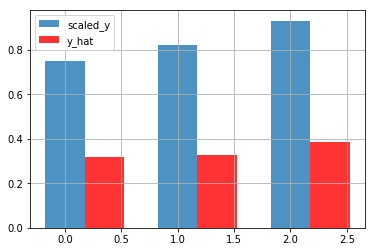

In [19]:
# Compare estimate, y_hat, to actual score
plt.bar([0.0, 1.0, 2.0], scaled_y.flatten(), width=0.35, alpha=0.8)
plt.bar([0.35, 1.35, 2.35], y_hat.flatten(), width=0.35, color='r', alpha=0.8)
plt.grid(1)
plt.legend(['scaled_y', 'y_hat'])

## Enter the cost function

Quantify exactly how wrong (or costly) the predictions were: take each error value, square it, and add values together.

"Training a network" means "minimising a cost function".

## Backpropagation

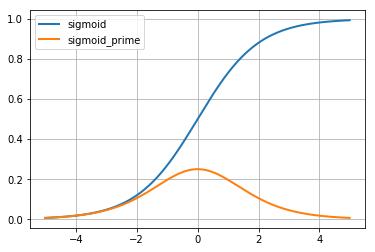

In [20]:
test_values = np.arange(-5, 5, 0.01)
plt.plot(test_values, sigmoid(test_values), linewidth=2)
plt.plot(test_values, sigmoid_prime(test_values), linewidth=2)
plt.grid(1)
plt.legend(['sigmoid', 'sigmoid_prime'])

## Next set of predictions

In [21]:
neural_network = NeuralNetwork()
cost1 = neural_network.cost_function(scaled_x, scaled_y)
djdw1, djdw2 = neural_network.cost_function_prime(scaled_x, scaled_y)

In [22]:
djdw1

array([[-0.01778355, -0.03167754,  0.03369079],
       [-0.01235642, -0.02084104,  0.02068435]])

In [23]:
djdw2

array([[-0.03567733],
       [-0.08644545],
       [-0.03242523]])

In [24]:
scalar = 3
neural_network.w1 = neural_network.w1 + scalar * djdw1
neural_network.w2 = neural_network.w2 + scalar * djdw2
cost2 = neural_network.cost_function(scaled_x, scaled_y)

In [25]:
print(cost1, cost2)

[0.08567656] [0.13042663]


In [26]:
djdw1, djdw2 = neural_network.cost_function_prime(x, y)
neural_network.w1 = neural_network.w1 - scalar * djdw1
neural_network.w2 = neural_network.w2 - scalar * djdw2
cost3 = neural_network.cost_function(scaled_x, scaled_y)

In [27]:
print(cost2, cost3)

[0.13042663] [0.0499]


## Numerical Gradient Checking

In [88]:
def compute_numerical_gradient(neural_network, x, y):
    params_initial = neural_network.get_params()
    numgrad = np.zeros(params_initial.shape)
    perturb = np.zeros(params_initial.shape)
    e = 1e-4

    for p in range(len(params_initial)):
        # Set perturbation vector
        perturb[p] = e
        neural_network.set_params(params_initial + perturb)
        loss2 = neural_network.cost_function(x, y)
            
        neural_network.set_params(params_initial - perturb)
        loss1 = neural_network.cost_function(x, y)

        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2 * e)

        # Return the value we changed to zero:
        perturb[p] = 0
            
    # Return Params to original value:
    neural_network.set_params(params_initial)

    return numgrad

In [29]:
neural_network = NeuralNetwork()
numgrad = compute_numerical_gradient(neural_network, scaled_x, scaled_y)
numgrad

array([ 0.01485662, -0.00090304,  0.02511734,  0.01180054, -0.00064456,
        0.02158281, -0.28842793, -0.19209932, -0.10747781])

In [30]:
grad = neural_network.compute_gradients(scaled_x, scaled_y)
grad

array([ 0.01485662, -0.00090304,  0.02511734,  0.01180054, -0.00064456,
        0.02158281, -0.28842793, -0.19209932, -0.10747781])

In [31]:
np.linalg.norm(grad - numgrad) / np.linalg.norm(grad + numgrad)

3.965989260930491e-10

> NOTE: [`norm`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html)

## Training

In [32]:
class Trainer:
    def __init__(self, n):
        # Make Local reference to network:
        self.n = n
        
    def callback_f(self, params):
        self.n.set_params(params)
        self.j.append(self.n.cost_function(self.x, self.y))   
        
    def cost_function_wrapper(self, params, x, y):
        self.n.set_params(params)
        cost = self.n.cost_function(x, y)
        grad = self.n.compute_gradients(x, y)
        
        return cost, grad
        
    def train(self, x, y):
        # Make an internal variable for the callback function:
        self.x = x
        self.y = y

        # Make empty list to store costs:
        self.j = []
        
        params0 = self.n.get_params()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.cost_function_wrapper, params0, jac=True, method='BFGS', \
                                 args=(x, y), options=options, callback=self.callback_f)

        self.n.set_params(_res.x)
        self.optimization_results = _res

In [33]:
neural_network = NeuralNetwork()
trainer = Trainer(neural_network)
trainer.train(scaled_x, scaled_y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


Text(0, 0.5, 'Cost')

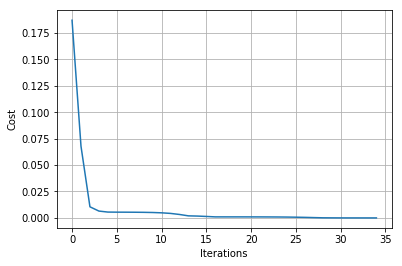

In [34]:
plt.plot(trainer.j)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [35]:
neural_network.cost_function_prime(scaled_x, scaled_y)

(array([[ 1.12876897e-06, -1.22678895e-07,  4.79469465e-07],
        [ 7.75961728e-06, -1.49556747e-06, -7.71798116e-06]]),
 array([[7.87668907e-07],
        [8.65414383e-07],
        [1.03587805e-06]]))

In [36]:
neural_network.forward(scaled_x)

array([[0.75005597],
       [0.8199691 ],
       [0.9299569 ]])

In [37]:
# Test network for various combinations of sleep/study:
hours_sleep = np.linspace(0, 10, 100)
hours_study = np.linspace(0, 5, 100)

# Normalize data (same way training data way normalized)
hours_sleep_norm = hours_sleep / 10.
hours_study_norm = hours_study / 5.

# Create 2-d versions of input for plotting
a, b  = np.meshgrid(hours_sleep_norm, hours_study_norm)

# Join into a single input matrix:
all_inputs = np.zeros((a.size, 2))
all_inputs[:, 0] = a.ravel()
all_inputs[:, 1] = b.ravel()

In [38]:
all_outputs = neural_network.forward(all_inputs)

Text(0, 0.5, 'Hours Study')

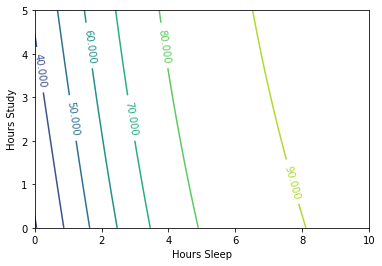

In [39]:
# Contour Plot:
yy = np.dot(hours_study.reshape(100,1), np.ones((1,100)))
xx = np.dot(hours_sleep.reshape(100,1), np.ones((1,100))).T

cs = plt.contour(xx, yy, 100 * all_outputs.reshape(100, 100))
plt.clabel(cs, inline=1, fontsize=10)
plt.xlabel('Hours Sleep')
plt.ylabel('Hours Study')

Text(0.5, 0, 'Test Score')

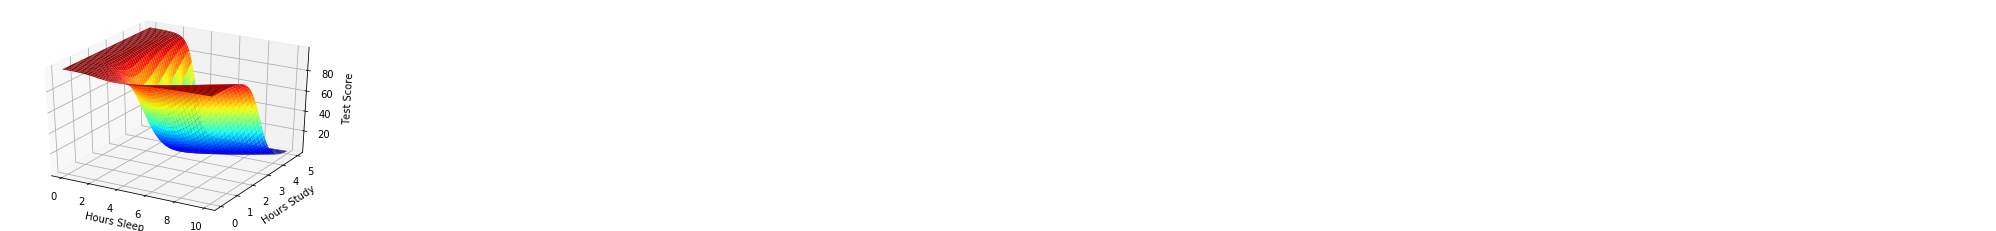

In [63]:
# 3D plot:

## Uncomment to plot out-of-notebook (you'll be able to rotate)
# %matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx, yy, 100 * all_outputs.reshape(100, 100), cmap=plt.cm.jet)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

## Overfitting, Testing, and Regularization

In [45]:
neural_network = NeuralNetwork()
# x = (hours sleeping, hours studying), y = Score on test
x = np.array(([3, 5], [5, 1], [10, 2], [6, 1.5]), dtype=float)
y = np.array(([75], [82], [93], [70]), dtype=float)

Text(0, 0.5, 'Test Score')

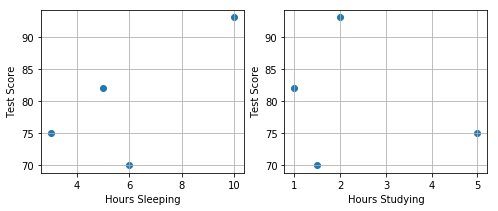

In [47]:
# Plot projections of our new data:
fig = plt.figure(0, (8, 3))

plt.subplot(1, 2,1)
plt.scatter(x[:, 0], y)
plt.grid(1)
plt.xlabel('Hours Sleeping')
plt.ylabel('Test Score')

plt.subplot(1, 2, 2)
plt.scatter(x[:, 1], y)
plt.grid(1)
plt.xlabel('Hours Studying')
plt.ylabel('Test Score')

> [Python array notation](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html)<br />
> The basic slice syntax is *i\:j\:k* where *i* is the starting index, *j* is the stopping index, and *k* is the step

In [48]:
# Normalize
x = x / np.amax(x, axis=0)
y = y / 100 # Max test score is 100

In [49]:
# Train network with new data:
trainer = Trainer(neural_network)
trainer.train(x, y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 99
         Function evaluations: 112
         Gradient evaluations: 112


Text(0, 0.5, 'Cost')

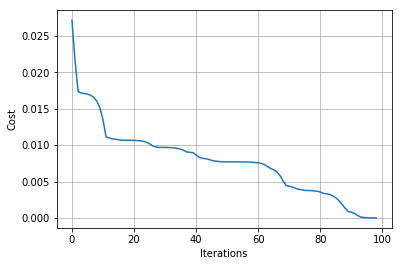

In [50]:
# Plot cost during training:
plt.plot(trainer.j)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [56]:
# Test network for various combinations of sleep/study:
hours_sleep = np.linspace(0, 10, 100)
hours_study = np.linspace(0, 5, 100)

# Normalize data (same way training data way normalized)
hours_sleep_norm = hours_sleep / 10.
hours_study_norm = hours_study / 5.

# Create 2-d versions of input for plotting
a, b  = np.meshgrid(hours_sleep_norm, hours_study_norm)

# Join into a single input matrix:
all_inputs = np.zeros((a.size, 2))
all_inputs[:, 0] = a.ravel()
all_inputs[:, 1] = b.ravel()

> [`linspace`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linspace.html)<br />
> Return evenly spaced numbers over a specified interval.

In [57]:
all_outputs = neural_network.forward(all_inputs)

Text(0, 0.5, 'Hours Study')

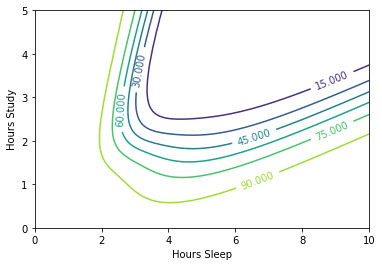

In [58]:
# Contour Plot:
yy = np.dot(hours_study.reshape(100,1), np.ones((1,100)))
xx = np.dot(hours_sleep.reshape(100,1), np.ones((1,100))).T

cs = plt.contour(xx, yy, 100 * all_outputs.reshape(100, 100))
plt.clabel(cs, inline=1, fontsize=10)
plt.xlabel('Hours Sleep')
plt.ylabel('Hours Study')

Text(0.5, 0, 'Test Score')

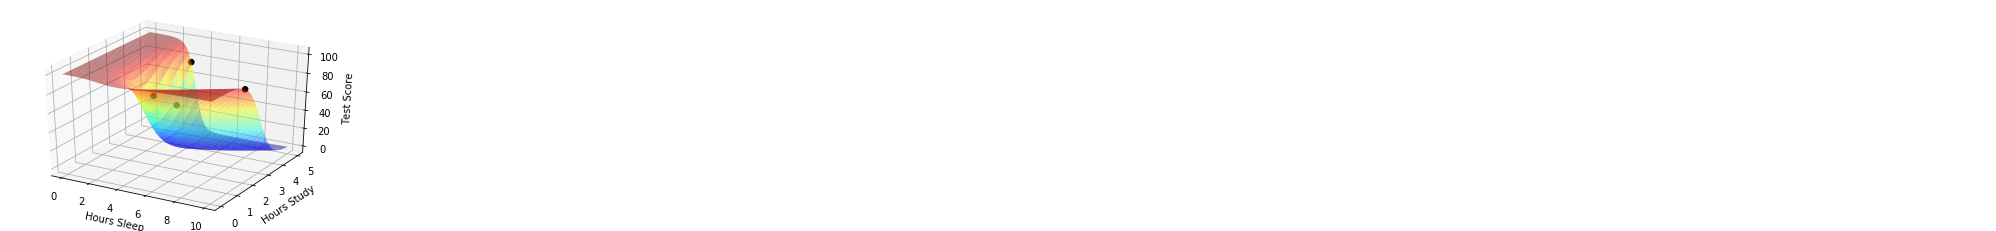

In [60]:
# 3D plot:
# Uncomment to plot out-of-notebook (you'll be able to rotate)
# %matplotlib qt

fig = plt.figure()
ax = fig.gca(projection='3d')

# Scatter training examples:
ax.scatter(10 * x[:,0], 5 * x[:,1], 100 * y, c='k', alpha=1, s=30)

surf = ax.plot_surface(xx, yy, 100 * all_outputs.reshape(100, 100), \
                       cmap=plt.cm.jet, alpha = 0.5)


ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

In [64]:
# Training Data:
train_x = np.array(([3, 5], [5, 1], [10, 2], [6, 1.5]), dtype=float)
train_y = np.array(([75], [82], [93], [70]), dtype=float)

# Testing Data:
test_x = np.array(([4, 5.5], [4.5, 1], [9, 2.5], [6, 2]), dtype=float)
test_y = np.array(([70], [89], [85], [75]), dtype=float)

# Normalize:
train_x = train_x / np.amax(train_x, axis=0)
train_y = train_y / 100 # Max test score is 100

# Normalize by max of training data:
test_x = test_x / np.amax(train_x, axis=0)
test_y = test_y / 100 # Max test score is 100

In [65]:
## Need to modify trainer class a bit to check testing error during training:
class Trainer:
    def __init__(self, n):
        # Make Local reference to network:
        self.n = n
        
    def callback_f(self, params):
        self.n.set_params(params)
        self.j.append(self.n.cost_function(self.x, self.y))
        self.test_j.append(self.n.cost_function(self.test_x, self.test_y))
        
    def cost_function_wrapper(self, params, x, y):
        self.n.set_params(params)
        cost = self.n.cost_function(x, y)
        grad = self.n.compute_gradients(x, y)
        
        return cost, grad
        
    def train(self, train_x, train_y, test_x, test_y):
        # Make an internal variable for the callback function:
        self.x = train_x
        self.y = train_y
        
        self.test_x = test_x
        self.test_y = test_y

        # Make empty list to store training costs:
        self.j = []
        self.test_j = []
        
        params0 = self.n.get_params()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.cost_function_wrapper, params0, jac=True, method='BFGS', \
                                 args=(train_x, train_y), options=options, callback=self.callback_f)

        self.n.set_params(_res.x)
        self.optimization_results = _res

In [66]:
# Train network with new data:
neural_network = NeuralNetwork()
trainer = Trainer(neural_network)
trainer.train(train_x, train_y, test_x, test_y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 171
         Function evaluations: 195
         Gradient evaluations: 195


Text(0, 0.5, 'Cost')

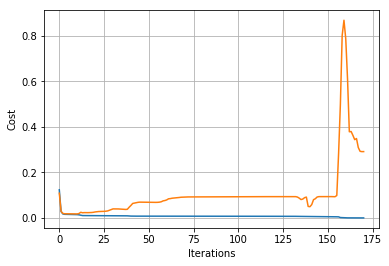

In [67]:
# Plot cost during training:
plt.plot(trainer.j)
plt.plot(trainer.test_j)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')

### Mitigate overfitting with regularisation

In [93]:
# Re-define class with edits to cost_function and cost_function_prime
class NeuralNetwork:
    def __init__(self, regularization_lambda=0):        
        # Define Hyperparameters
        self.input_layer_size = 2
        self.output_layer_size = 1
        self.hidden_layer_size = 3
        
        # Weights (parameters)
        self.w1 = np.random.randn(self.input_layer_size, self.hidden_layer_size)
        self.w2 = np.random.randn(self.hidden_layer_size, self.output_layer_size)
        
        # Regularization Parameter:
        self.regularization_lambda = regularization_lambda
        
    def forward(self, x):
        # Propagate inputs though network
        self.z2 = np.dot(x, self.w1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.w2)
        y_hat = self.sigmoid(self.z3) 
        return y_hat
    
    def sigmoid(self, z):
        # Apply sigmoid activation function to scalar, vector, or matrix
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_prime(self, z):
        # Gradient of sigmoid
        return np.exp(-z) / (1 + np.exp(-z))**2
    
    def cost_function(self, x, y):
        # Compute cost for given x,y, use weights already stored in class.
        self.y_hat = self.forward(x)
        # We don't want cost to increase with the number of examples,
        # so normalize by dividing the error term by number of examples(x.shape[0])
        j = 0.5 * sum((y - self.y_hat)**2) / x.shape[0] + (self.regularization_lambda / 2) * \
            (sum(self.w1**2) + sum(self.w2**2))
        return j
        
    def cost_function_prime(self, x, y):
        # Compute derivative with respect to w1 and w2 for a given x and y:
        self.y_hat = self.forward(x)
        
        delta3 = np.multiply(-(y - self.y_hat), self.sigmoid_prime(self.z3))
        # Add gradient of regularization term:
        djdw2 = np.dot(self.a2.T, delta3) / x.shape[0] + self.regularization_lambda * self.w2
        
        delta2 = np.dot(delta3, self.w2.T) * self.sigmoid_prime(self.z2)
        # Add gradient of regularization term:
        djdw1 = np.dot(x.T, delta2) / x.shape[0] + self.regularization_lambda * self.w1
        
        return djdw1, djdw2
    
    def get_params(self):
        # Get w1 and w2 unrolled into vector:
        params = np.concatenate((self.w1.ravel(), self.w2.ravel()))
        return params
    
    def set_params(self, params):
        # Set w1 and w2 using single paramater vector.
        w1_start = 0
        w1_end = self.hidden_layer_size * self.input_layer_size
        self.w1 = np.reshape(params[w1_start:w1_end], (self.input_layer_size , self.hidden_layer_size))
        w2_end = w1_end + self.hidden_layer_size * self.output_layer_size
        self.w2 = np.reshape(params[w1_end:w2_end], (self.hidden_layer_size, self.output_layer_size))
        
    def compute_gradients(self, x, y):
        djdw1, djdw2 = self.cost_function_prime(x, y)
        return np.concatenate((djdw1.ravel(), djdw2.ravel()))

In [94]:
neural_network = NeuralNetwork(regularization_lambda=0.0001)

In [96]:
# Make sure our gradients our correct after making changes:
# NOTE: numgrad currently throws a `ValueError: setting an array element with a sequence` error
# numgrad = compute_numerical_gradient(neural_network, x, y)
grad = neural_network.compute_gradients(x, y)
# Should be less than 1e-8:
# plt.norm(grad - numgrad) / plt.norm(grad + numgrad)

In [98]:
trainer = Trainer(neural_network)
# Currently throws `ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()` error
# trainer.train(x, y, test_x, test_y)

In [100]:
# plt.plot(trainer.j)
# plt.plot(trainer.test_j)
# plt.grid(1)
# plt.xlabel('Iterations')
# plt.ylabel('Cost')

Text(0, 0.5, 'Hours Study')

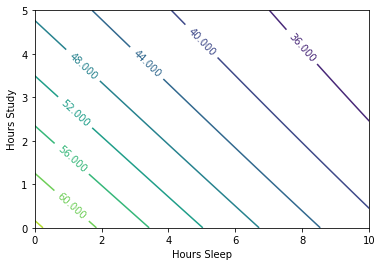

In [102]:
all_outputs = neural_network.forward(all_inputs)

# Contour Plot:
yy = np.dot(hours_study.reshape(100, 1), np.ones((1, 100)))
xx = np.dot(hours_sleep.reshape(100,1), np.ones((1, 100))).T

cs = plt.contour(xx, yy, 100 * all_outputs.reshape(100, 100))
plt.clabel(cs, inline=1, fontsize=10)
plt.xlabel('Hours Sleep')
plt.ylabel('Hours Study')

Text(0.5, 0, 'Test Score')

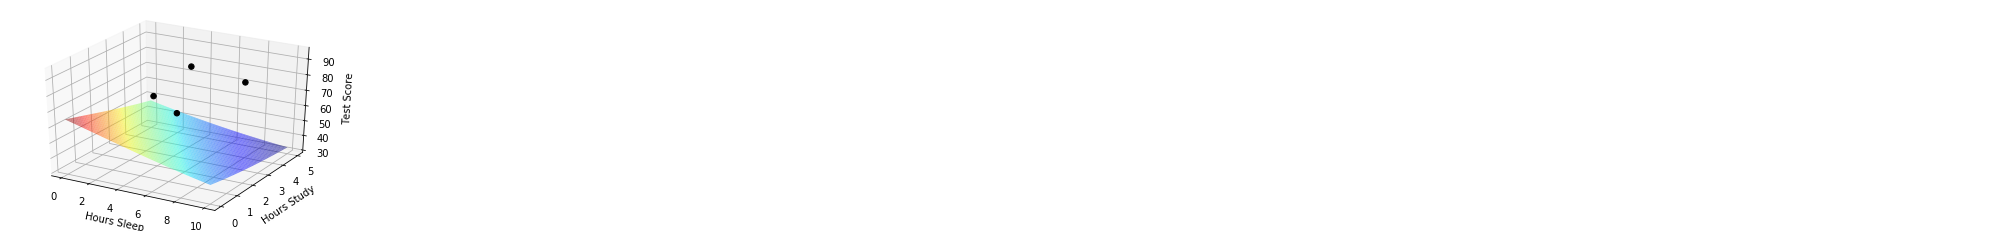

In [103]:
# 3D plot:
## Uncomment to plot out-of-notebook (you'll be able to rotate)
#%matplotlib qt

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(10 * x[:, 0], 5 * x[:,1], 100 * y, c='k', alpha=1, s=30)


surf = ax.plot_surface(xx, yy, 100 * all_outputs.reshape(100, 100), \
                       cmap=plt.cm.jet, alpha = 0.5)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')